In [1]:
'''
Import necessary libraries
'''

import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
%matplotlib inline

In [2]:
# Read Train and Test dataset
data_train = pd.read_csv("data/KDDTrain+.txt")
data_test = pd.read_csv("data/KDDTest+.txt")

In [3]:
# Check data
data_train.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [6]:
# Get columns name for data
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'outcome'
,'level'])

In [7]:
# Assign name for columns
data_train.columns = columns
data_test.columns  = columns

In [10]:
# Choose categorical columns to remove because PCA show good performance with numeric data
columns_drop = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level']

In [11]:
# Remove the categorical data
data_train.drop(columns_drop, axis=1, inplace=True)
data_train.shape

(125972, 35)

In [12]:
data_train.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,232,8153,0,0,0,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,199,420,0,0,0,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,0,0,0,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


### To learn principal components from data, it is reasonable for us to use only normal data to train model.

The principal component will be used to detect normal data which has short distance to principal components

In [13]:
# Get all normal data to train
data_train_normal = data_train[data_train['outcome']=='normal'].copy()
data_train_normal.shape

(67342, 35)

In [14]:
# Remove label before training
data_train_normal.drop(columns=['outcome'], axis=1, inplace=True)
data_train_normal.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,146,0,0,0,0,0,0,0,0,...,255,1,0.0,0.6,0.88,0.00,0.00,0.00,0.0,0.00
2,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01
3,0,199,420,0,0,0,0,0,0,0,...,255,255,1.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00
11,0,287,2251,0,0,0,0,0,0,0,...,8,219,1.0,0.0,0.12,0.03,0.00,0.00,0.0,0.00
15,0,300,13788,0,0,0,0,0,0,0,...,91,255,1.0,0.0,0.01,0.02,0.00,0.00,0.0,0.00


In [15]:
data_test.drop(columns_drop, axis=1, inplace=True)
data_test.shape

(22543, 35)

In [16]:
# Get all normal and  abnormal data for accuracy estimation later easier
data_test_normal = data_test[data_test['outcome']=='normal'].copy()
data_test_abnormal = data_test[data_test['outcome']!='normal'].copy()
data_test_normal.drop(columns=['outcome'], axis=1, inplace=True)
data_test_abnormal.drop(columns=['outcome'], axis=1, inplace=True)
data_test_normal.shape, data_test_abnormal.shape

((9711, 34), (12832, 34))

In [17]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [18]:
df_train = data_train_normal.copy()
df_test = pd.concat([data_test_normal, data_test_abnormal])
df_test.columns = data_test_normal.columns

In [19]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = data_test_normal.columns

In [20]:
from sklearn.decomposition import PCA
def perform_pca(df_train, df_test):
  pca = PCA(0.9)
  pca.fit(scaler.transform(df_train))
  # we don't use built-in fit_transform() since we fit on train and transform over test. In fact, we can fit(df_train) and transform(df_test) as well.
  # source code: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/decomposition/_pca.py#L411
  # df_test_PCA_manual = (df_test-scaler.mean_).dot(pca.components_.T)
  # df_test_PCA_inverse_manual = df_test_PCA_manual.dot(pca.components_) + scaler.mean_
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  print(pca.components_.shape)
  return df_test_PCA, df_test_PCA_inverse

In [21]:
# Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)
abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)
df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(data_test_normal)), np.ones(len(data_test_abnormal))])
df_gt_score_PCA['anomalyScore'] = abnormal_score

(19, 34)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    # print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

### Fine Tune And Prediction
To make a classification with PCA, we need to choose a threshold which data obtaining higher score than threshold will be classified as abnormal data

In [23]:
lst_rho = np.linspace(0.0001,0.001,10)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001 ]


#### Effect of threshold on performance of PCA for attack detection

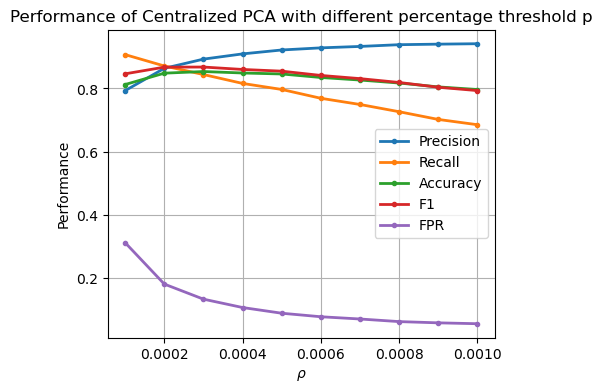

In [24]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
plt.legend()
plt.grid()
plt.title("Performance of Centralized PCA with different percentage threshold p")
plt.show()

#### Performance Evaluation

In [25]:
precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.0003, log=1)

Precision: 89.2763%
Recall: 84.4062%
Accuracy score: 85.3524%
F1 score: 86.773%
False alarm: 13.3972%
